<a href="https://colab.research.google.com/github/santyxd3000/Undergraduate-Project/blob/main/Classifying_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE GRADO - MODELOS DE CLASIFICACIÓN**

Santiago Pardo Morales - 202013025

In [1]:
#For using the GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 4.55 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 568.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import datetime
import scipy
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import io
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import cudf
import cuml
import cupy as cp
from cuml import preprocessing as cpp
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
physical_devices = tf.config.list_physical_devices('GPU')
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from cuml.svm import SVC
from cuml.multiclass import OneVsOneClassifier
from cuml.multiclass import OneVsRestClassifier

In [50]:
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [8]:
#Leer datos etiquetados
df = pd.read_csv('df_with_labels.csv',sep=';').dropna()

In [9]:
df['Label'].unique()

array(['No Fault', 'Shading', 'Open Circuit', 'Unknown', 'Short Circuit'],
      dtype=object)

## **MÉTODO 1 - RED NEURONAL**

In [10]:
df['Label'].replace({'No Fault': 0, 'Shading': 1, 'Open Circuit': 2, 'Short Circuit': 3, 'Unknown':4}, inplace=True)

In [ ]:
df[df['Label']==1].shape

(47256, 6)

In [ ]:
x_data = df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = df[['Label']]

In [ ]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)
y_data = np.array(y_data)

In [ ]:
#Divide data
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

### Red Neuronal - Solo capa de entrada y de salida

In [ ]:
ann_1 = Sequential()
ann_1.add(Dense(4, input_shape=(x_train.shape[1],),activation='relu'))

#output layer with softmax function
ann_1.add(Dense(5,activation='softmax'))

#compile model
ann_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history= ann_1.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_1.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.3189 - accuracy: 0.9439 - val_loss: 0.1056 - val_accuracy: 0.9806
Epoch 2/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0822 - accuracy: 0.9823 - val_loss: 0.0721 - val_accuracy: 0.9819
Epoch 3/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0626 - accuracy: 0.9835 - val_loss: 0.0609 - val_accuracy: 0.9826
Epoch 4/100
2820/2820 [==============================] - 9s 3ms/step - loss: 0.0527 - accuracy: 0.9844 - val_loss: 0.0525 - val_accuracy: 0.9839
Epoch 5/100
2820/2820 [==============================] - 8s 3ms/step - loss: 0.0434 - accuracy: 0.9858 - val_loss: 0.0441 - val_accuracy: 0.9857
Epoch 6/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0370 - accuracy: 0.9876 - val_loss: 0.0401 - val_accuracy: 0.9887
Epoch 7/100
2820/2820 [==============================] - 9s 3ms/step - loss: 0.0341 - accuracy: 0.9903 - val_loss: 0.0387 - va

### Red Neuronal - Capa intermedia entre entrada y salida

In [ ]:
ann_2 = Sequential()
ann_2.add(Dense(16, input_shape=(x_train.shape[1],),activation='relu'))
ann_2.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_2.add(Dense(5,activation='softmax'))

#compile model
ann_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history= ann_2.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_2.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.1932 - accuracy: 0.9629 - val_loss: 0.0429 - val_accuracy: 0.9906
Epoch 2/100
2820/2820 [==============================] - 10s 4ms/step - loss: 0.0326 - accuracy: 0.9921 - val_loss: 0.0336 - val_accuracy: 0.9910
Epoch 3/100
2820/2820 [==============================] - 10s 4ms/step - loss: 0.0280 - accuracy: 0.9926 - val_loss: 0.0324 - val_accuracy: 0.9908
Epoch 4/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0265 - accuracy: 0.9927 - val_loss: 0.0312 - val_accuracy: 0.9907
Epoch 5/100
2820/2820 [==============================] - 9s 3ms/step - loss: 0.0252 - accuracy: 0.9928 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 6/100
2820/2820 [==============================] - 10s 4ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0278 - val_accuracy: 0.9913
Epoch 7/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0235 - accuracy: 0.9932 - val_loss: 0.0280 - 

### Red Neuronal - 2 capas intermedia entre entrada y salida

In [ ]:
ann_3 = Sequential()
ann_3.add(Dense(64, input_shape=(x_train.shape[1],),activation='relu'))
ann_3.add(Dense(16 ,activation='relu'))
ann_3.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_3.add(Dense(5,activation='softmax'))

#compile model
ann_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history= ann_3.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_3.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.0953 - accuracy: 0.9715 - val_loss: 0.0372 - val_accuracy: 0.9901
Epoch 2/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.0304 - val_accuracy: 0.9914
Epoch 3/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0262 - val_accuracy: 0.9916
Epoch 4/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0266 - val_accuracy: 0.9907
Epoch 5/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0227 - accuracy: 0.9928 - val_loss: 0.0245 - val_accuracy: 0.9911
Epoch 6/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0223 - val_accuracy: 0.9925
Epoch 7/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0193 - accuracy: 0.9934 - val_loss: 0.0280 -

### Red Neuronal - 3 capas intermedia entre entrada y salida

In [ ]:
ann_4 = Sequential()
ann_4.add(Dense(256, input_shape=(x_train.shape[1],),activation='relu'))
ann_4.add(Dense(64 ,activation='relu'))
ann_4.add(Dense(16 ,activation='relu'))
ann_4.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_4.add(Dense(5,activation='softmax'))

#compile model
ann_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history= ann_4.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_4.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 14s 4ms/step - loss: 0.0640 - accuracy: 0.9852 - val_loss: 0.0350 - val_accuracy: 0.9908
Epoch 2/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0284 - accuracy: 0.9916 - val_loss: 0.0300 - val_accuracy: 0.9912
Epoch 3/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0264 - val_accuracy: 0.9915
Epoch 4/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.0232 - val_accuracy: 0.9918
Epoch 5/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.0244 - val_accuracy: 0.9915
Epoch 6/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0189 - accuracy: 0.9933 - val_loss: 0.0227 - val_accuracy: 0.9922
Epoch 7/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0173 - accuracy: 0.9940 - val_loss: 0.0185 -

### Red Neuronal - 4 capas intermedia entre entrada y salida

In [ ]:
ann_5 = Sequential()
ann_5.add(Dense(256, input_shape=(x_train.shape[1],),activation='relu'))
ann_5.add(Dense(64 ,activation='relu'))
ann_5.add(Dense(16 ,activation='relu'))
ann_5.add(Dense(4 ,activation='relu'))
ann_5.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_5.add(Dense(5,activation='softmax'))

#compile model
ann_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history= ann_5.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_5.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 16s 5ms/step - loss: 0.0838 - accuracy: 0.9689 - val_loss: 0.0348 - val_accuracy: 0.9907
Epoch 2/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0306 - accuracy: 0.9916 - val_loss: 0.0315 - val_accuracy: 0.9913
Epoch 3/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0292 - val_accuracy: 0.9912
Epoch 4/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0240 - val_accuracy: 0.9920
Epoch 5/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0275 - val_accuracy: 0.9901
Epoch 6/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0203 - val_accuracy: 0.9930
Epoch 7/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0178 - accuracy: 0.9943 - val_loss: 0.0180 -

### Modelo Escogido - Red Neuronal con 2 capas intermedias entre entrada y salida

In [ ]:
ann_predict_test = ann_3.predict(x_test)

940/940 [==============================] - 2s 2ms/step


In [ ]:
ann_predict_test = np.argmax(ann_predict_test, axis=1)

<Figure size 3000x800 with 0 Axes>

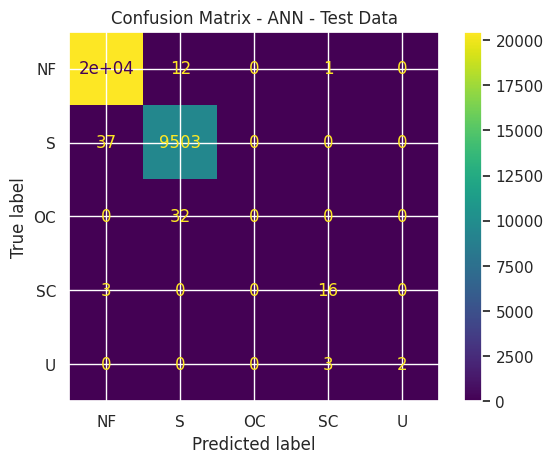

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['NF','S','OC','SC','U']

cm = confusion_matrix(y_test, ann_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(30,8))
disp.plot()
plt.title("Confusion Matrix - ANN - Test Data")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, ann_predict_test)
precision = precision_score(y_test, ann_predict_test,average='weighted')
recall = recall_score(y_test, ann_predict_test,average='weighted')
f1_score = f1_score(y_test, ann_predict_test,average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9970744680851064
Precision: 0.9960201102432343
Recall: 0.9970744680851064
F1-Score: 0.9965252391235436


## **MÉTODO 2 - SUPPORT VECTOR MACHINES**

In [12]:
cu_df = cudf.DataFrame(df)

In [28]:
x_data = cu_df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = cu_df[['Label']]

In [29]:
cu_scaler = cuml.preprocessing.StandardScaler()
x_scaled = cu_scaler.fit_transform(x_data)
y_data = y_data.to_cupy()

In [39]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

x_train = x_train.to_numpy()
y_train = y_train.ravel()
y_train = cp.asnumpy(y_train)
x_val = x_val.to_numpy()
y_val = y_val.ravel()
y_val = cp.asnumpy(y_val)
x_test = x_test.to_numpy()
y_test = y_test.ravel()
y_test = cp.asnumpy(y_test)

In [63]:
svc_classifier = SVC(kernel='rbf',gamma='scale',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Scale:  {'C': 1000.0}


In [58]:
svc_classifier = SVC(kernel='rbf',gamma='auto',decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Auto:  {'C': 1000.0}


In [ ]:
svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)

Best Parameters for SVM with Sigmoid Kernel:  {'C': 0.001}


In [61]:
svc_classifier = SVC(kernel='poly',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
    "degree": np.array([1,2,3,4,5,6]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Polynomial Kernel: ", grid_search_ovr.best_params_)


KeyboardInterrupt: 

In [ ]:
svc_classifier = SVC(kernel='rbf',gamma='scale',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Scale:  {'C': 1000.0}


In [ ]:
svc_classifier = SVC(kernel='rbf',gamma='auto',decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Auto:  {'C': 1000.0}


In [ ]:
svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)

Best Parameters for SVM with Sigmoid Kernel:  {'C': 0.001}


In [ ]:
svc_classifier = SVC(kernel='rbf',gamma='scale',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Scale:  {'C': 1000.0}


In [ ]:
svc_classifier = SVC(kernel='rbf',gamma='auto',decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)

Best Parameters for SVM with RBF Kernel and Gamma Auto:  {'C': 1000.0}


In [ ]:
svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)

Best Parameters for SVM with Sigmoid Kernel:  {'C': 0.001}


In [ ]:
svc_classifier = SVC(kernel='poly',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
    "degree": np.array([1,2,3,4,5,6]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Polynomial Kernel: ", grid_search_ovr.best_params_)


KeyboardInterrupt: 

In [ ]:
svc_classifier = SVC(kernel='poly',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
    "degree": np.array([1,2,3,4,5,6]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and Polynomial Kernel: ", grid_search_ovr.best_params_)


KeyboardInterrupt: 